# Dynamic R-CNN

This notebook details how the Dynamic R-CNN model was trained 4-folds, benchmarked and evaluated

install necessary libraries

In [ ]:
from google.colab import drive
import os
import cv2
import json
import torch
import random
import supervision as sv
import numpy as np
import shutil
from google.colab import runtime
from mmdet.apis import init_detector, inference_detector
from supervision.draw.color import Color


installing versions of pytorch and libraries compatible with mmdetection

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 fastapi kaleido python-multipart uvicorn lida torchdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

installing supervision compatible with mmdetection

In [ ]:
!pip install -q supervision==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 2.4 MB/s eta 0:00:00


 setting the variable HOME to the current working directory by using the os.getcwd() function from Python's os module for easy reference of home directory

In [ ]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Setting up up the environment for using MMDetection by installing necessary compatible versions of dependencies (mmengine, mmcv, mmdet), cloning the MMDetection repository, and installing it in an editable mode.

In [ ]:
%cd {HOME}

%pip install -U -q openmim



!mim install "mmengine>=0.7.0"
!mim install "mmcv==2.0.0rc4"

!mim install -q "mmdet>=3.0.0rc6,<3.1.0"



!git clone https://github.com/open-mmlab/mmdetection.git


%cd {HOME}/mmdetection

%pip install -e .

Mount google drive to access data stored.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


downloading pretrained weights for faster training of the model

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://download.openmmlab.com/mmdetection/v2.0/dynamic_rcnn/dynamic_rcnn_r50_fpn_1x/dynamic_rcnn_r50_fpn_1x-62a3f276.pth
!ls -lh {HOME}/weights

total 160M
-rw-r--r-- 1 root root 160M Nov  2  2021 dynamic_rcnn_r50_fpn_1x-62a3f276.pth


Setting up a custom configuration file for the model which defines

* Configuration Path: Sets the path for saving the custom configuration.
* Base Model: Inherits from a Faster R-CNN config and customizes it for the specific dataset.
* Dataset and DataLoader: Configures paths, batch sizes, and annotations for training, validation, and testing datasets.
* Model Architecture: Tailors the roi_head for a single-class detection task, adjusting bounding box heads and loss functions.
* Learning Rate Scheduling: Implements a two-stage learning rate scheduler with linear warm-up and cosine annealing.
* Training Pipeline: Defines data augmentation for the second training stage.
* Optimizer: Uses AdamW with specific learning rates and weight decay settings.
* Hooks: Includes early stopping, checkpointing, and logging to monitor and optimize the training process.
* Pretrained Weights: Loads COCO-pretrained weight to initialize the model.
* Training Loop: Uses an epoch-based training loop with validation at each epoch.
* Visualization: Configures visualizers, including TensorBoard, for monitoring.

In [ ]:
#early stopping
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/dynamic_rcnn/custom_dynamic_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = '../faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_1/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 150
base_lr = 0.0001
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    roi_head=dict(
        type='DynamicRoIHead',
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1,  # Change num_classes to 1 since you have only one class
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))),
    train_cfg=dict(
        rpn_proposal=dict(nms=dict(iou_threshold=0.85)),
        rcnn=dict(
            dynamic_rcnn=dict(
                iou_topk=75,
                beta_topk=10,
                update_iter_interval=100,
                initial_iou=0.4,
                initial_beta=1.0))),
    test_cfg=dict(rpn=dict(nms=dict(iou_threshold=0.85))))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/weights/dynamic_rcnn_r50_fpn_1x-62a3f276.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""


writing the custom configuration file to the folder

In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

Running training on the custom configuration file

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/dynamic_rcnn/custom_dynamic_rcnn.py

Streaming output truncated to the last 5000 lines.
07/10 19:22:54 - mmengine - INFO - Epoch(val)   [3][ 40/406]    eta: 0:00:23  time: 0.0634  data_time: 0.0029  memory: 802  
07/10 19:22:54 - mmengine - INFO - Epoch(val)   [3][ 45/406]    eta: 0:00:23  time: 0.0640  data_time: 0.0030  memory: 802  
07/10 19:22:55 - mmengine - INFO - Epoch(val)   [3][ 50/406]    eta: 0:00:23  time: 0.0649  data_time: 0.0030  memory: 808  
07/10 19:22:55 - mmengine - INFO - Epoch(val)   [3][ 55/406]    eta: 0:00:22  time: 0.0649  data_time: 0.0028  memory: 849  
07/10 19:22:55 - mmengine - INFO - Epoch(val)   [3][ 60/406]    eta: 0:00:22  time: 0.0647  data_time: 0.0028  memory: 823  
07/10 19:22:55 - mmengine - INFO - Epoch(val)   [3][ 65/406]    eta: 0:00:21  time: 0.0644  data_time: 0.0027  memory: 811  
07/10 19:22:56 - mmengine - INFO - Epoch(val)   [3][ 70/406]    eta: 0:00:21  time: 0.0647  data_time: 0.0027  memory: 823  
07/10 19:22:56 - mmengine - INFO - Epoch(val)   [3][ 75/406]    eta: 0:00:

saving training results to a folder

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_dynamic_rcnn'
destination_folder = '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-1fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-1fold'

Defining custom configuration file for 2nd fold with checkpoint of the model trained in the previous fold and saving the training result

In [ ]:
#2nd fold
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/dynamic_rcnn/custom_dynamic_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = '../faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_3/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 150
base_lr = 0.0001
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    roi_head=dict(
        type='DynamicRoIHead',
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1,  # Change num_classes to 1 since you have only one class
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))),
    train_cfg=dict(
        rpn_proposal=dict(nms=dict(iou_threshold=0.85)),
        rcnn=dict(
            dynamic_rcnn=dict(
                iou_topk=75,
                beta_topk=10,
                update_iter_interval=100,
                initial_iou=0.4,
                initial_beta=1.0))),
    test_cfg=dict(rpn=dict(nms=dict(iou_threshold=0.85))))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-2fold/epoch_11.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/dynamic_rcnn/custom_dynamic_rcnn.py

/content/mmdetection
07/11 17:57:45 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1692713145
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;a

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_dynamic_rcnn'
destination_folder = '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-3fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-3fold'

Defining custom configuration file for 3rd fold with checkpoint of the model trained in the previous fold and saving the training result

In [ ]:
#3rd fold
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/dynamic_rcnn/custom_dynamic_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = '../faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_2/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 150
base_lr = 0.0001
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    roi_head=dict(
        type='DynamicRoIHead',
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1,  # Change num_classes to 1 since you have only one class
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))),
    train_cfg=dict(
        rpn_proposal=dict(nms=dict(iou_threshold=0.85)),
        rcnn=dict(
            dynamic_rcnn=dict(
                iou_topk=75,
                beta_topk=10,
                update_iter_interval=100,
                initial_iou=0.4,
                initial_beta=1.0))),
    test_cfg=dict(rpn=dict(nms=dict(iou_threshold=0.85))))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-1fold/epoch_29.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/dynamic_rcnn/custom_dynamic_rcnn.py

/content/mmdetection
07/11 16:47:46 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 329535111
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;ar

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_dynamic_rcnn'
destination_folder = '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-2fold'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-2fold'

Defining a custom configuration file for the 4th fold, incorporating rotation augmentation to improve performance on detecting rotated images, using the checkpoint from the model trained in the previous fold, and saving the training results.

In [ ]:
#early stopping
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/dynamic_rcnn/custom_dynamic_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = '../faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset3/2024-07-07_5-Fold_Cross-val/split_4/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 150
base_lr = 0.0001
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/images/'),
        ann_file='val/images/annotations.json',))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val/images/annotations.json')

test_evaluator = val_evaluator

model = dict(
    roi_head=dict(
        type='DynamicRoIHead',
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1,  # Change num_classes to 1 since you have only one class
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))),
    train_cfg=dict(
        rpn_proposal=dict(nms=dict(iou_threshold=0.85)),
        rcnn=dict(
            dynamic_rcnn=dict(
                iou_topk=75,
                beta_topk=10,
                update_iter_interval=100,
                initial_iou=0.4,
                initial_beta=1.0))),
    test_cfg=dict(rpn=dict(nms=dict(iou_threshold=0.85))))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomRotate', angle_range=(-100, 100), prob=0.5),  # Adding random rotation
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomRotate', angle_range=(-10, 10), prob=0.5),  # Adding random rotation
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]


# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-3fold/epoch_11.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/dynamic_rcnn/custom_dynamic_rcnn.py

/content/mmdetection
07/15 08:46:35 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 725096053
    GPU 0: NVIDIA L4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;ar

In [ ]:
#saving best run result

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_dynamic_rcnn'
destination_folder = '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2'

Command to disconnect runtime after training

In [ ]:
runtime.unassign()

# Benchmarking

Code to calculate memory usage of the model

In [ ]:
%cd {HOME}/mmdetection
!python tools/analysis_tools/benchmark.py configs/dynamic_rcnn/custom_dynamic_rcnn.py --checkpoint /content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2/epoch_6.pth --dataset-type val --fuse-conv-bn

/content/mmdetection
07/15 19:33:42 - mmengine - INFO - before build: 
07/15 19:33:42 - mmengine - INFO - (GB) mem_used: 1.66 | uss: 0.32 | pss: 0.40 | total_proc: 1
loading annotations into memory...
Done (t=3.80s)
creating index...
index created!
07/15 19:33:47 - mmengine - INFO - after build: 
07/15 19:33:47 - mmengine - INFO - (GB) mem_used: 1.75 | uss: 0.37 | pss: 0.45 | total_proc: 1
07/15 19:33:58 - mmengine - INFO - ==================================
07/15 19:33:58 - mmengine - INFO - Done batch [50 /2000], fps: 4.6 batch/s, times per batch: 216.8 ms/batch, batch size: 1, num_workers: 2
07/15 19:33:58 - mmengine - INFO - (GB) mem_used: 1.83 | uss: 0.13 | pss: 0.53 | total_proc: 3
07/15 19:34:09 - mmengine - INFO - ==================================
07/15 19:34:09 - mmengine - INFO - Done batch [100/2000], fps: 4.6 batch/s, times per batch: 215.3 ms/batch, batch size: 1, num_workers: 2
07/15 19:34:09 - mmengine - INFO - (GB) mem_used: 1.84 | uss: 0.17 | pss: 0.57 | total_proc: 3

# Evaluation

Code to calculate performance metrics like recall, mAP50, mAP75 and mAP50-95

In [ ]:
%cd {HOME}/mmdetection
!python tools/test.py configs/dynamic_rcnn/custom_dynamic_rcnn.py '/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2/epoch_6.pth' --out results.pkl

/content/mmdetection
07/15 19:53:24 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 1736165305
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_U

# Inference

Code to perform inference on images using the trained model

In [ ]:
CUSTOM_WEIGHTS_PATH = "/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2/epoch_6.pth"

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = init_detector(CUSTOM_CONFIG_PATH, CUSTOM_WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2/epoch_6.pth


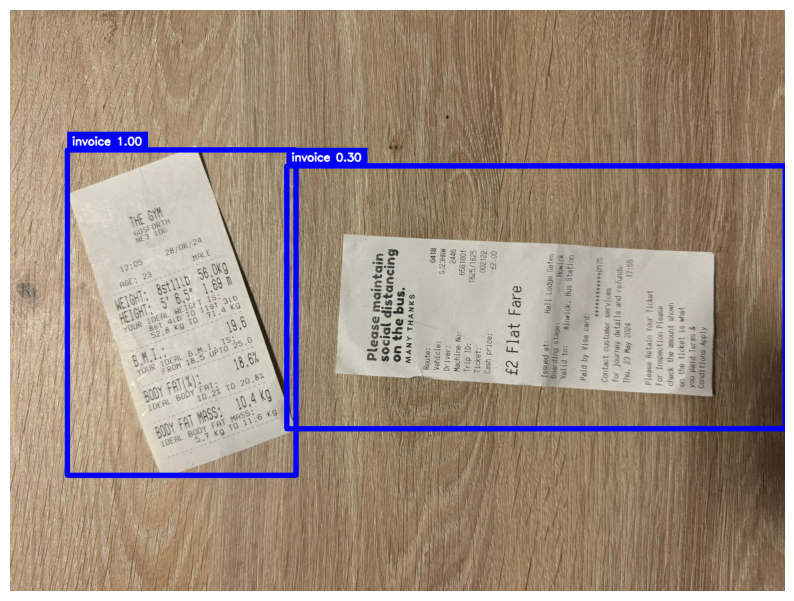

In [ ]:
# Define the class names
classes = ['invoice']

# Load the image
IMAGE_PATH = "/content/drive/MyDrive/Test photos/inv_scenarios_3.jpg"
image = cv2.imread(IMAGE_PATH)

# Perform the inference
result = inference_detector(model, image)

# Convert the results to supervision Detections
detections = sv.Detections.from_mmdetection(result)


labels = [
     f"{classes[class_id]} {confidence:0.2f}"
     for _, _, confidence, class_id, _
     in detections
 ]

# Annotate the image with class names
box_annotator = sv.BoxAnnotator(thickness=10,text_scale=0.75,text_color=Color.white(),text_thickness=2,color=Color.blue())
annotated_image = box_annotator.annotate(image.copy(), detections,labels=labels)

# Plot the annotated image
sv.plot_image(image=annotated_image, size=(10, 10))




---
# Experimentation Codes


This section contains pieces of code used for testing or experimenting

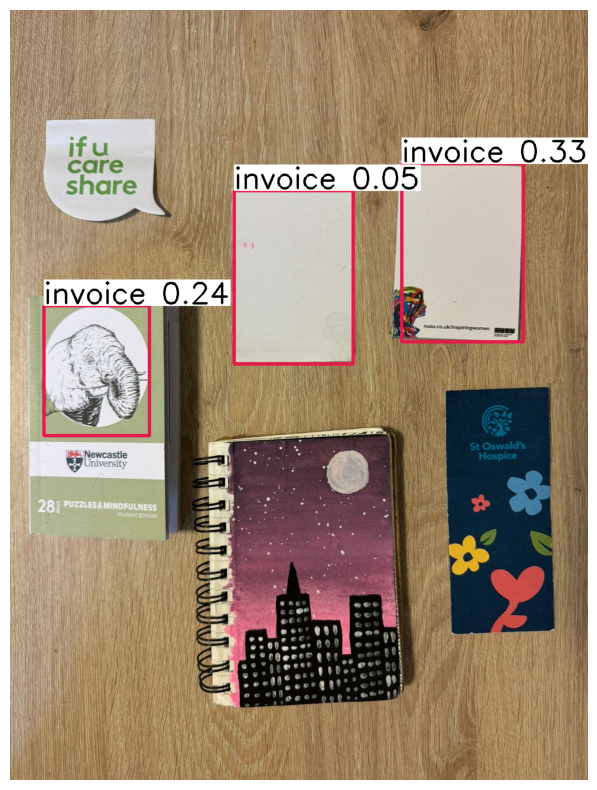

In [ ]:
import cv2
import supervision as sv
from mmdet.apis import inference_detector

# Define the class names
classes = ['invoice']

# Load the image
IMAGE_PATH = "/content/drive/MyDrive/Test photos/blanks_bookmark_painting_green-paper.jpg"
image = cv2.imread(IMAGE_PATH)

# Perform the inference
result = inference_detector(model, image)

# Convert the results to supervision Detections
detections = sv.Detections.from_mmdetection(result)

# Define the labels with class names and confidence scores
labels = [
    f"{classes[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]

# Annotate the image with bounding boxes
box_annotator = sv.BoxAnnotator(thickness=5)
annotated_image = box_annotator.annotate(image.copy(), detections, labels=labels)

# Function to draw labels with larger font size
def draw_labels(image, detections, labels, font_scale=0.5, font_thickness=2):
    for (bbox, label) in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = map(int, bbox)
        text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        text_w, text_h = text_size
        cv2.rectangle(image, (x1, y1 - text_h - 10), (x1 + text_w, y1), (255, 255, 255), -1)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)
    return image

# Draw the labels with the specified font size and thickness
annotated_image_with_labels = draw_labels(annotated_image, detections, labels, font_scale=2, font_thickness=3)

# Plot the annotated image with larger labels
sv.plot_image(image=annotated_image_with_labels, size=(10, 10))


Without K-Fold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 fastapi kaleido python-multipart uvicorn lida torchdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 914.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd {HOME}

%pip install -U -q openmim


!mim install -q "mmdet>=3.0.0rc6,<3.1.0"


!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"


!git clone https://github.com/open-mmlab/mmdetection.git


%cd {HOME}/mmdetection

%pip install -e .

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
!pip install -q supervision==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 1.2 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import json
import torch
import random
import supervision as sv
import numpy as np

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://download.openmmlab.com/mmdetection/v2.0/dynamic_rcnn/dynamic_rcnn_r50_fpn_1x/dynamic_rcnn_r50_fpn_1x-62a3f276.pth
!ls -lh {HOME}/weights

total 160M
-rw-r--r-- 1 root root 160M Nov  2  2021 dynamic_rcnn_r50_fpn_1x-62a3f276.pth


In [ ]:
BATCH_SIZE = 8
MAX_EPOCHS = 50

In [ ]:
#early stopping
CUSTOM_CONFIG_PATH = f"{HOME}/mmdetection/configs/dynamic_rcnn/custom_dynamic_rcnn.py"

CUSTOM_CONFIG = """
# Inherit and overwrite part of the config based on this config
_base_ = '../faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py'

data_root = '/content/drive/MyDrive/Combined Dataset2/'  # Ensure this points to your dataset root

train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 150
base_lr = 0.0001
stage2_num_epochs = 1

metainfo = {
    'classes': ('invoice', ),  # Replace 'your_class' with the name of your class
    'palette': [
        (220, 20, 60),
    ]
}

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/images/'),
        ann_file='train/images/annotations.json',))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='valid/images/'),
        ann_file='valid/images/annotations.json',))

test_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='test/images/'),
        ann_file='test/images/annotations.json',))

val_evaluator = dict(ann_file=data_root + 'valid/images/annotations.json')

test_evaluator = dict(ann_file=data_root + 'test/images/annotations.json')

model = dict(
    roi_head=dict(
        type='DynamicRoIHead',
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=1,  # Change num_classes to 1 since you have only one class
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))),
    train_cfg=dict(
        rpn_proposal=dict(nms=dict(iou_threshold=0.85)),
        rcnn=dict(
            dynamic_rcnn=dict(
                iou_topk=75,
                beta_topk=10,
                update_iter_interval=100,
                initial_iou=0.4,
                initial_beta=1.0))),
    test_cfg=dict(rpn=dict(nms=dict(iou_threshold=0.85))))

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

train_pipeline_stage2 = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='YOLOXHSVRandomAug'),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    early_stopping=dict(
        type='EarlyStoppingHook',
        monitor='coco/bbox_mAP',
        patience=10,
        min_delta=0.01),
    checkpoint=dict(
        type='CheckpointHook',
        interval=5,
        save_begin=1,
        max_keep_ckpts=2,
        save_best='auto'),
    logger=dict(type='LoggerHook', interval=5))

custom_hooks = [
    dict(
        type='PipelineSwitchHook',
        switch_epoch=max_epochs - 1,
        switch_pipeline=train_pipeline_stage2)
]

# load COCO pre-trained weight
load_from = '/content/weights/dynamic_rcnn_r50_fpn_1x-62a3f276.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')])
"""


In [ ]:
with open(CUSTOM_CONFIG_PATH, 'w') as file:
    file.write(CUSTOM_CONFIG)

In [ ]:
%cd {HOME}/mmdetection
!python tools/train.py configs/dynamic_rcnn/custom_dynamic_rcnn.py

Streaming output truncated to the last 5000 lines.
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
launcher = 'none'
load_from = '/content/weights/dynamic_rcnn_r50_fpn_1x-62a3f276.pth'
log_level = 'INFO'
log_processor = dict(by_epoch=True, type='LogProcessor', window_size=50)
max_epochs = 150
metainfo = dict(
    classes=('invoice', ), palette=[
        (
            220,
            20,
            60,
        ),
    ])
model = dict(
    backbone=dict(
        depth=50,
        frozen_stages=1,
        init_cfg=dict(checkpoint='torchvision://resnet50', type='Pretrained'),
        norm_cfg=dict(requires_grad=True, type='BN'),
        norm_eval=True,
        num_stages=4,
        out_indices=(
            0,
            1,
         

In [ ]:
#saving best run result
import shutil

# Source and destination paths
source_folder = '/content/mmdetection/work_dirs/custom_dynamic_rcnn'
destination_folder = '/content/drive/MyDrive/Dynamic_R_CNN_runs/dynamicrcnn150epochs-best26'

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/Dynamic_R_CNN_runs/dynamicrcnn150epochs-best26'

In [ ]:
from mmdet.apis import init_detector, inference_detector

In [ ]:
CUSTOM_WEIGHTS_PATH = "/content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2/epoch_6.pth"

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = init_detector(CUSTOM_CONFIG_PATH, CUSTOM_WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /content/drive/MyDrive/Dynamic_R_CNN_runs/kfolds/dynamicrcnn150epochs-4fold-2/epoch_6.pth


In [ ]:
evaluation = dict(interval=1, metric=['bbox'], save_best='bbox_mAP_50')

In [ ]:
!python tools/test.py '/content/mmdetection/configs/dynamic_rcnn/custom_dynamic_rcnn.py' '/content/drive/MyDrive/Dynamic_R_CNN_runs/dynamicrcnn150epochs-best26/epoch_26.pth' --out results.pkl

06/26 08:05:30 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 1503303189
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-

In [ ]:
# Calculate F1 Score
precision = 0.920
recall = 0.883
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

0.901120354963949

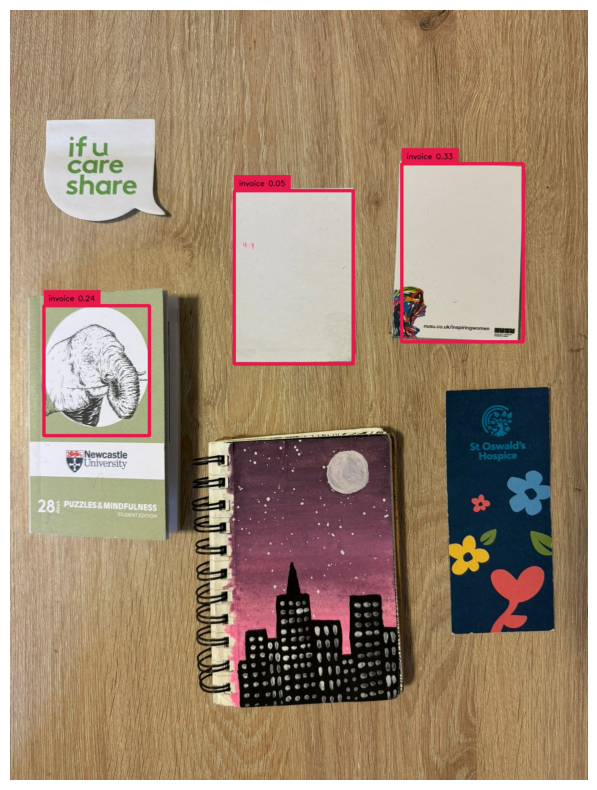

In [ ]:
import cv2
import supervision as sv
from mmdet.apis import inference_detector

# Define the class names
classes = ['invoice']

labels = [
     f"{classes[class_id]} {confidence:0.2f}"
     for _, _, confidence, class_id, _
     in detections
 ]

# Load the image
IMAGE_PATH = "/content/drive/MyDrive/Test photos/blanks_bookmark_painting_green-paper.jpg"
image = cv2.imread(IMAGE_PATH)

# Perform the inference
result = inference_detector(model, image)

# Convert the results to supervision Detections
detections = sv.Detections.from_mmdetection(result)

# Annotate the image with class names
box_annotator = sv.BoxAnnotator(thickness=5)
annotated_image = box_annotator.annotate(image.copy(), detections,labels=labels)

# Plot the annotated image
sv.plot_image(image=annotated_image, size=(10, 10))


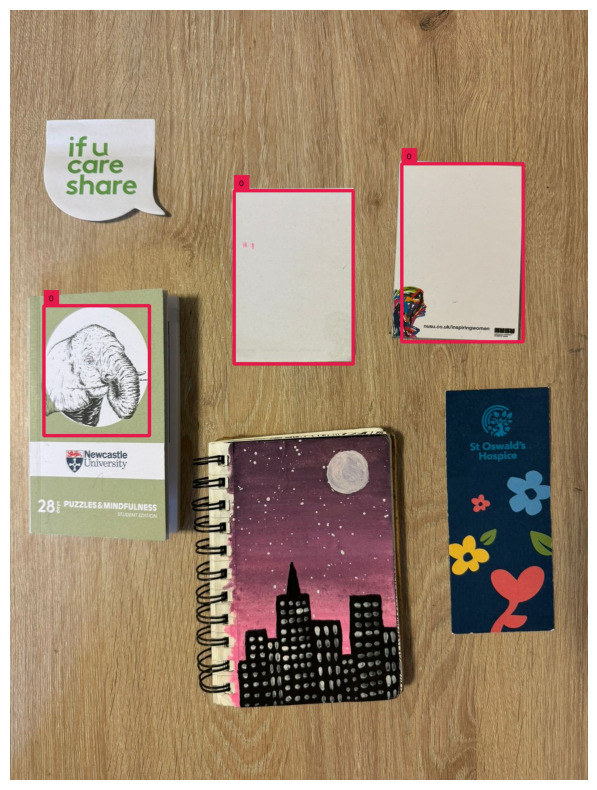

In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/Test photos/blanks_bookmark_painting_green-paper.jpg"
image = cv2.imread(IMAGE_PATH)
result = inference_detector(model, image)

detections = sv.Detections.from_mmdetection(result)
box_annotator = sv.BoxAnnotator(thickness=5)
annotated_image = box_annotator.annotate(image.copy(), detections)
sv.plot_image(image=annotated_image, size=(10, 10))